## Data Brief

World Health Organization has estimated 12 million deaths occur worldwide, every year due to heart diseases. Half the deaths in developed countries are due to cardio vascular diseases. The early prognosis of cardiovascular diseases can aid in making decisions on lifestyle changes in high risk patients and in turn reduce the complications. The classification goal of this project is to predict whether a patient has 10-year risk of future coronary heart disease (CHD).

The dataset is publically available on the Kaggle website, and it is from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts.The dataset provides the patients’ information. It includes about 3,000 records and 15 attributes. Each attribute is a potential risk factor. There are demographic, behavioral and medical risk factors.

**Demographic**:
- sex: male or female ("M" or "F")
- age: age of the patient (Continuous, although the recorded ages have been truncated to whole numbers, the concept of age is continuous)

**Behavioral**:
- is_smoking: whether or not the patient is a current smoker ("YES" or "NO")
- cigsPerDay: the number of cigarettes that the person smoked on average in one day (can be considered continuous as one can have any number of cigarettes, even half a cigarette.)

**Medical (history)**:
- BPMeds: whether or not the patient was on blood pressure medication (Nominal)
- prevalentStroke: whether or not the patient had previously had a stroke (Nominal)
- prevalentHyp: whether or not the patient was hypertensive (Nominal)
- diabetes: whether or not the patient had diabetes (Nominal)

**Medical (current)**:
- totChol: total cholesterol level (Continuous)
- sysBP: systolic blood pressure (Continuous)
- diaBP: diastolic blood pressure (Continuous)
- BMI: Body Mass Index (Continuous)
- heartRate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)
- glucose: glucose level (Continuous)

**Target variable**:
- TenYearCHD: 10 year risk of coronary heart disease (binary: “1”, means “Yes”, “0” means “No”)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
import statsmodels.api as sm
from sklearn.metrics import roc_curve
from scipy.stats import norm
from sklearn.impute import KNNImputer
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import shap

%matplotlib inline
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.2f}'.format

## Data Cleaning

In [2]:
df_train = pd.read_csv('cardio_train.csv', index_col=0)
df_train.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
0,64,2.00,F,YES,3.00,0.00,0,0,0,221.00,148.00,85.00,NaN,90.00,80.00,1
1,36,4.00,M,NO,0.00,0.00,0,1,0,212.00,168.00,98.00,29.77,72.00,75.00,0
2,46,1.00,F,YES,10.00,0.00,0,0,0,250.00,116.00,71.00,20.35,88.00,94.00,0
3,50,1.00,M,YES,20.00,0.00,0,1,0,233.00,158.00,88.00,28.26,68.00,94.00,1
4,64,1.00,F,YES,30.00,0.00,0,0,0,241.00,136.50,85.00,26.42,70.00,77.00,0


In [3]:
df_train['sex'] = df_train['sex'].map({'F': 1, 'M': 0})
df_train.rename(columns={'sex': 'is_female'}, inplace=True)

df_train['is_smoking'] = df_train['is_smoking'].map({'YES': 1, 'NO': 0})

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3390 non-null   int64  
 1   education        3303 non-null   float64
 2   is_female        3390 non-null   int64  
 3   is_smoking       3390 non-null   int64  
 4   cigsPerDay       3368 non-null   float64
 5   BPMeds           3346 non-null   float64
 6   prevalentStroke  3390 non-null   int64  
 7   prevalentHyp     3390 non-null   int64  
 8   diabetes         3390 non-null   int64  
 9   totChol          3352 non-null   float64
 10  sysBP            3390 non-null   float64
 11  diaBP            3390 non-null   float64
 12  BMI              3376 non-null   float64
 13  heartRate        3389 non-null   float64
 14  glucose          3086 non-null   float64
 15  TenYearCHD       3390 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 450.2 KB


In [5]:
df_train.describe()

,age,education,is_female,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,"3,390.00","3,303.00","3,390.00","3,390.00","3,368.00","3,346.00","3,390.00","3,390.00","3,390.00","3,352.00","3,390.00","3,390.00","3,376.00","3,389.00","3,086.00","3,390.00"
mean,49.54,1.97,0.57,0.50,9.07,0.03,0.01,0.32,0.03,237.07,132.60,82.88,25.79,75.98,82.09,0.15
std,8.59,1.02,0.50,0.50,11.88,0.17,0.08,0.46,0.16,45.25,22.29,12.02,4.12,11.97,24.24,0.36
min,32.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,107.00,83.50,48.00,15.96,45.00,40.00,0.00
25%,42.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,117.00,74.50,23.02,68.00,71.00,0.00
50%,49.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,234.00,128.50,82.00,25.38,75.00,78.00,0.00
75%,56.00,3.00,1.00,1.00,20.00,0.00,0.00,1.00,0.00,264.00,144.00,90.00,28.04,83.00,87.00,0.00
max,70.00,4.00,1.00,1.00,70.00,1.00,1.00,1.00,1.00,696.00,295.00,142.50,56.80,143.00,394.00,1.00


In [6]:
missing_values = df_train.isnull().sum()
missing_percentage = (df_train.isnull().mean() * 100)

missing_data = pd.DataFrame({'missing values': missing_values, 'percentage': missing_percentage})
missing_data

,missing values,percentage
age,0,0.00
education,87,2.57
is_female,0,0.00
is_smoking,0,0.00
cigsPerDay,22,0.65
BPMeds,44,1.30
prevalentStroke,0,0.00
prevalentHyp,0,0.00
diabetes,0,0.00
totChol,38,1.12


Total percentage of missing values ~ 15%. Instead of deleting this data, we can replace it using KNN algorithm.

In [7]:
df_train_copy = df_train.copy()

### Handling missing values

In [8]:
imputer = KNNImputer(n_neighbors=5)
    
df_train_copy = pd.DataFrame(imputer.fit_transform(df_train_copy), columns=df_train_copy.columns)
    
df_train_copy[
    [
        'age', 'education', 'is_female', 'is_smoking', 
        'cigsPerDay', 'BPMeds', 'prevalentStroke', 
        'prevalentHyp', 'diabetes', 'TenYearCHD'
    ]
] = df_train_copy[
    [
        'age', 'education', 'is_female', 'is_smoking', 
        'cigsPerDay', 'BPMeds', 'prevalentStroke', 
        'prevalentHyp', 'diabetes', 'TenYearCHD'
    ]
].astype(int)

### Handling outliers

In [9]:
threshold = 3

columns = ['cigsPerDay', 'totChol', 'sysBP', 'BMI', 'heartRate', 'glucose']

z_scores = stats.zscore(df_train_copy[columns])

z_scores_df = pd.DataFrame(z_scores, columns=columns, index=df_train_copy.index)

outliers = (z_scores_df > threshold) | (z_scores_df < -threshold)

mask = (~outliers).all(axis=1)

df_train_copy = df_train_copy[mask]

In [10]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3221 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3221 non-null   int64  
 1   education        3221 non-null   int64  
 2   is_female        3221 non-null   int64  
 3   is_smoking       3221 non-null   int64  
 4   cigsPerDay       3221 non-null   int64  
 5   BPMeds           3221 non-null   int64  
 6   prevalentStroke  3221 non-null   int64  
 7   prevalentHyp     3221 non-null   int64  
 8   diabetes         3221 non-null   int64  
 9   totChol          3221 non-null   float64
 10  sysBP            3221 non-null   float64
 11  diaBP            3221 non-null   float64
 12  BMI              3221 non-null   float64
 13  heartRate        3221 non-null   float64
 14  glucose          3221 non-null   float64
 15  TenYearCHD       3221 non-null   int64  
dtypes: float64(6), int64(10)
memory usage: 427.8 KB


## EDA

#### Functions for later use

In [11]:
def plot_countplot(df, column, title='', xlabel='', ylabel='Count', palette='Dark2', 
                   hue=None, legend=False, legend_title=None, legend_labels=None, 
                   tick_labels=None, ax=None):
    """
    Plots a count plot for a specified column of a DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data to plot.
    column : str
        The name of the column to plot.
    title : str, optional
        The title of the plot (default is an empty string).
    xlabel : str, optional
        The label for the x-axis (default is 'Count').
    ylabel : str, optional
        The label for the y-axis (default is 'Count').
    palette : str or list, optional
        The color palette to use for the plot (default is 'Dark2').
    hue : str, optional
        The name of the column to use for color encoding (default is None).
    legend : bool, optional
        Whether to display the legend (default is False).
    legend_title : str, optional
        The title for the legend (default is None).
    legend_labels : list, optional
        Custom labels for the legend (default is None).
    tick_labels : list, optional
        Custom labels for the x-axis ticks (default is None).
    ax : matplotlib.axes.Axes, optional
        The axes on which to plot the count plot (default is None, which creates a new figure).

    Returns
    -------
    None
        Displays the count plot.
    """

    if ax is None:
        plt.figure(figsize=(11, 4))
        ax = plt.gca()

    sns.countplot(data=df, x=column, palette=palette, edgecolor='black', hue=hue, ax=ax)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if tick_labels is not None:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(tick_labels)
    
    if legend and legend_labels is not None:
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles, legend_labels, title=legend_title)


def plot_histogram(df, column, bins, title='', xlabel='', ylabel='Frequency', 
                   palette='Dark2', hue='TenYearCHD', legend=False, ax=None):
    """
    Plots a histogram for a specified column of a DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data to plot.
    column : str
        The name of the column to plot.
    bins : int
        The number of bins for the histogram.
    title : str, optional
        The title of the plot (default is an empty string).
    xlabel : str, optional
        The label for the x-axis (default is the column name).
    ylabel : str, optional
        The label for the y-axis (default is 'Frequency').
    palette : str or list, optional
        The color palette to use for the plot (default is 'Dark2').
    hue : str, optional
        The name of the column to use for color encoding (default is 'TenYearCHD').
    legend : bool, optional
        Whether to display the legend (default is False).
    ax : matplotlib.axes.Axes, optional
        The axes on which to plot the histogram (default is None, which creates a new figure).

    Returns
    -------
    None
        Displays the histogram.
    """

    if ax is None:
        plt.figure(figsize=(11, 4))
        ax = plt.gca()

    sns.histplot(data=df, x=column, bins=bins, hue=hue, palette=palette, 
                 multiple='stack', edgecolor='black', ax=ax)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

#### age

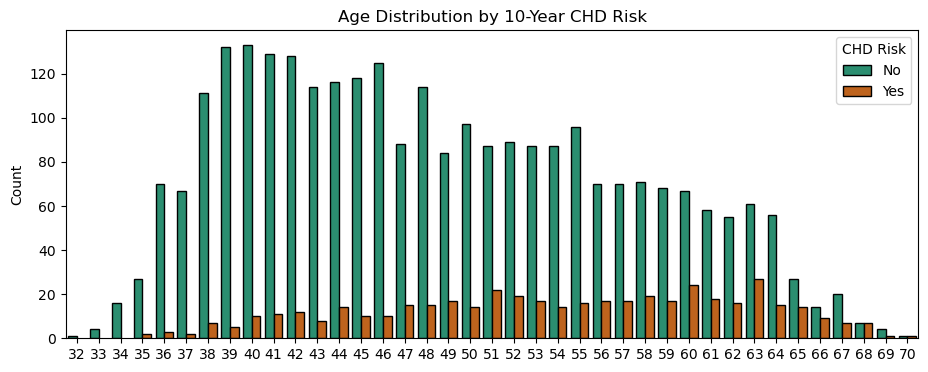

In [12]:
plot_countplot(
    df_train_copy, 
    'age', 
    title='Age Distribution by 10-Year CHD Risk', 
    palette='Dark2', 
    hue='TenYearCHD', 
    legend=True, 
    legend_title='CHD Risk', 
    legend_labels=['No', 'Yes']
)

The age range of the data, 32 to 70 years, is appropriate since cardiovascular diseases are often diagnosed from the 40s onwards. The plot shows that most individuals are in their 40s and 50s, with a noticeable increase in CHD risk starting in the mid-40s and becoming more prevalent after age 50. This trend aligns with the known correlation between advancing age and increased CHD risk.

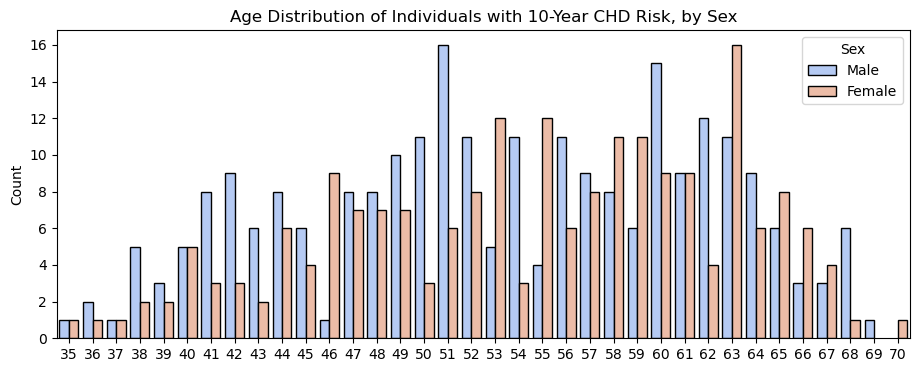

In [13]:
plot_countplot(
    df_train_copy[df_train_copy['TenYearCHD'] == 1], 
    'age', 
    title='Age Distribution of Individuals with 10-Year CHD Risk, by Sex', 
    palette='coolwarm', 
    hue='is_female', 
    legend=True, 
    legend_title='Sex', 
    legend_labels=['Male', 'Female']
)

There is a noticeable increase in CHD risk for both males and females from their 40s onwards, with peaks observed in the early 50s and early 60s. The data suggests that while the risk is present in both sexes, its distribution varies across different age groups.

#### education

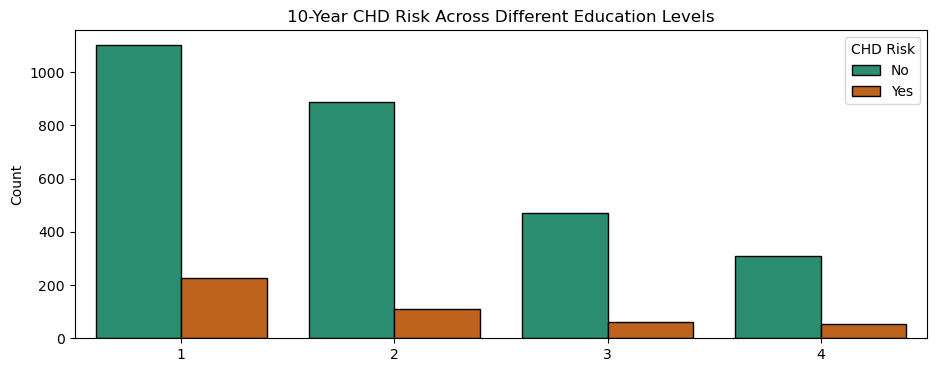

In [14]:
plot_countplot(
    df_train_copy, 
    'education', 
    title='10-Year CHD Risk Across Different Education Levels', 
    palette='Dark2', 
    hue='TenYearCHD', 
    legend=True, 
    legend_title='CHD Risk', 
    legend_labels=['No', 'Yes']
)

The chart suggests a possible correlation between lower education levels and a higher 10-year CHD risk, with the risk appearing more prevalent among individuals at level 1 education. However, the data is heavily skewed towards level 1, with fewer people at higher education levels, which may reflect a general trend in the dataset rather than a true correlation between education and CHD risk. Further analysis is needed to confirm whether this pattern represents a genuine relationship or is simply due to the distribution of education levels in the data.

#### sex

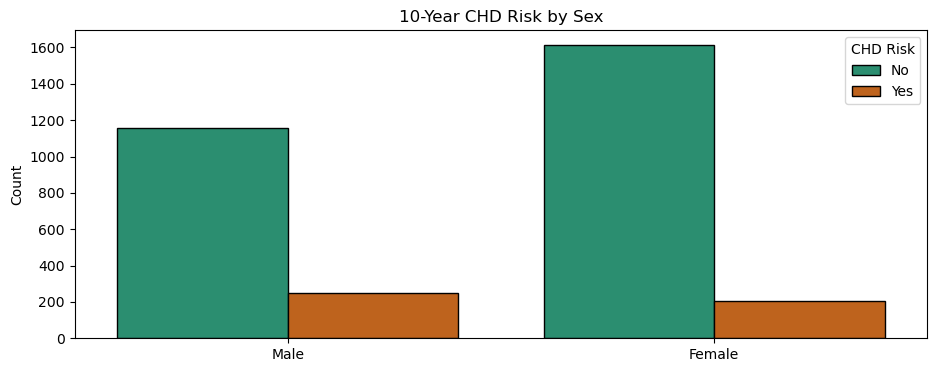

In [15]:
plot_countplot(
    df_train_copy,
    'is_female',
    title='10-Year CHD Risk by Sex',
    palette='Dark2',
    hue='TenYearCHD',
    legend=True,
    legend_title='CHD Risk',
    legend_labels=['No', 'Yes'],
    tick_labels=['Male', 'Female']
)

The chart shows that the number of people at risk for CHD is roughly similar between males and females, but the overall number of females in the dataset is higher. This suggests that the distribution of CHD risk is relatively balanced across sexes, despite there being more females represented in the data.

#### smoking

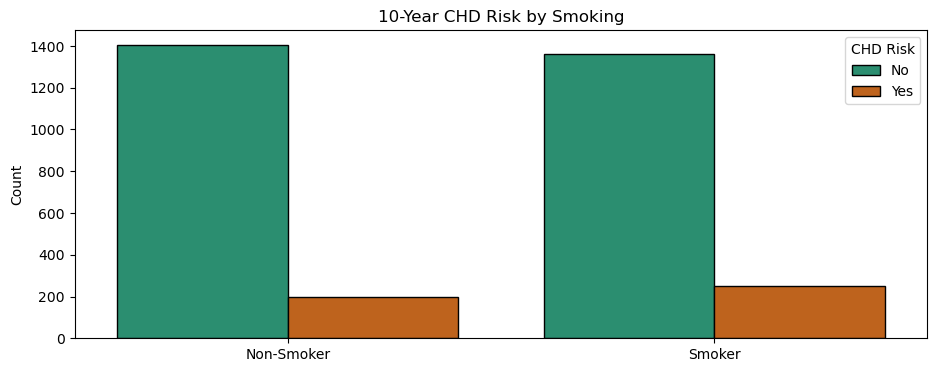

In [16]:
plot_countplot(
    df_train_copy,
    'is_smoking',
    title='10-Year CHD Risk by Smoking',
    palette='Dark2',
    hue='TenYearCHD',
    legend=True,
    legend_title='CHD Risk',
    legend_labels=['No', 'Yes'],
    tick_labels=['Non-Smoker', 'Smoker']
)

#### cigarettes per day

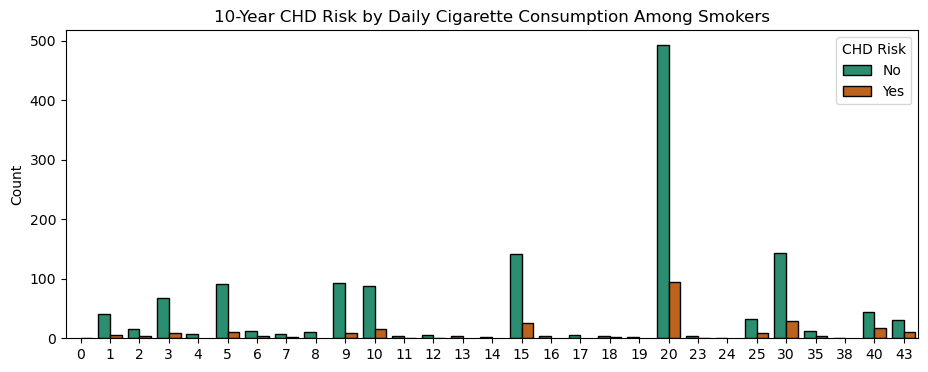

In [17]:
plot_countplot(
    df_train_copy[df_train_copy['is_smoking'] == 1],
    'cigsPerDay',
    title='10-Year CHD Risk by Daily Cigarette Consumption Among Smokers',
    palette='Dark2',
    hue='TenYearCHD',
    legend=True,
    legend_title='CHD Risk',
    legend_labels=['No', 'Yes']
)

While most smokers consume around 20 cigarettes per day, there is no clear pattern indicating that higher consumption is directly correlated with a higher CHD risk, as both risk groups appear across various levels of consumption.

#### BPMeds, prevalentStroke, prevalentHyp, diabetes

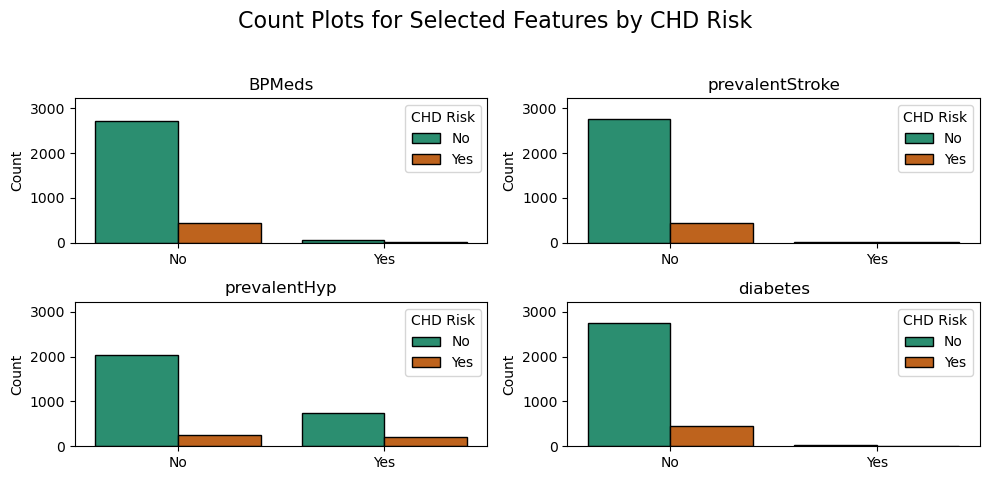

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
fig.suptitle('Count Plots for Selected Features by CHD Risk', fontsize=16)

features = ['BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

for i, feature in enumerate(features):
    row, col = divmod(i, 2)
    plot_countplot(
        df_train_copy,
        feature,
        title=feature,
        palette='Dark2',
        hue='TenYearCHD',
        legend=True,
        legend_title='CHD Risk',
        legend_labels=['No', 'Yes'],
        tick_labels=['No', 'Yes'],
        ax=axes[row, col]        
    )

plt.setp(axes, ylim=(0, df_train_copy[features].count().max()))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The count plots indicate that individuals with CHD risk make up a larger proportion of those who have the selected conditions (blood pressure medication use, history of stroke, high blood pressure, and diabetes). However, the overall number of individuals with these conditions is too small to draw any confident conclusions about a strong correlation between these factors and CHD risk.

#### totChol

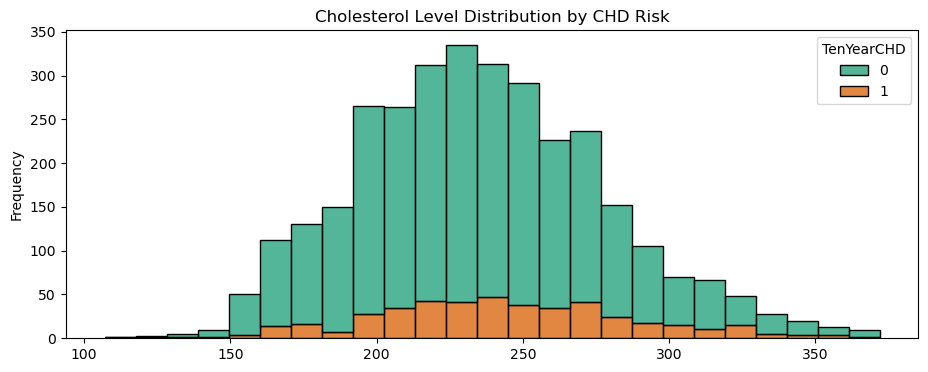

In [19]:
plot_histogram(
    df=df_train_copy,
    column='totChol', 
    bins=25,
    title='Cholesterol Level Distribution by CHD Risk',
    hue='TenYearCHD',
    legend=True
)

While cholesterol levels are generally similar across both groups, there is a slightly higher concentration of CHD risk individuals within the higher cholesterol ranges, suggesting that elevated cholesterol may contribute to increased CHD risk. However, the overall distribution overlaps significantly.

#### sysBP, diaBP, BMI, heartRate

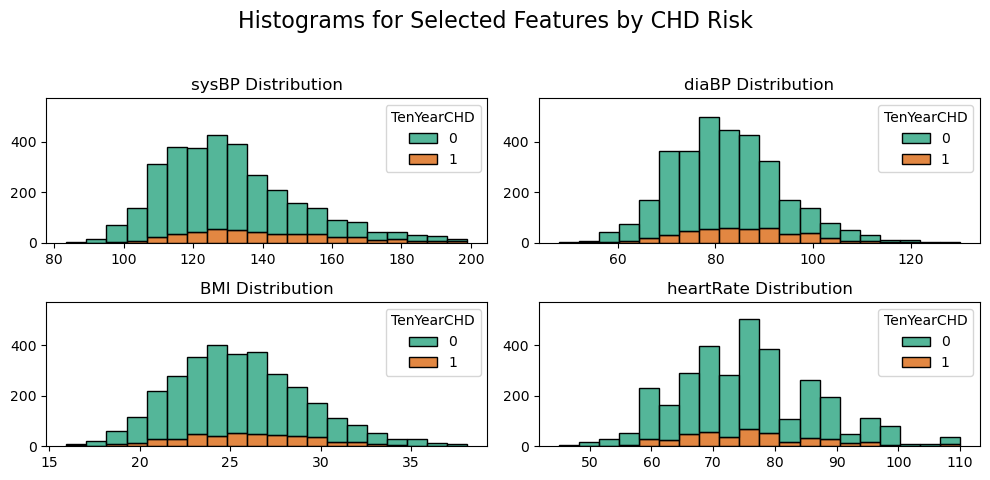

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
fig.suptitle('Histograms for Selected Features by CHD Risk', fontsize=16)

features = ['sysBP', 'diaBP', 'BMI', 'heartRate']

for i, feature in enumerate(features):
    row, col = divmod(i, 2)
    plot_histogram(
        df_train_copy,
        column=feature,
        bins=20,
        title=f'{feature} Distribution',
        ylabel='',
        palette='Dark2',
        hue='TenYearCHD',
        legend=True,
        ax=axes[row, col]
    )

plt.setp(axes, ylim=(0, 1.2*df_train_copy[features].max().sum()))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Top Left** (sysBP Distribution): The distribution shows that individuals with higher systolic blood pressure (sysBP) levels tend to have a slightly higher presence of CHD risk. However, there is considerable overlap between those with and without CHD risk, indicating that sysBP alone may not be a decisive factor.

**Top Right** (diaBP Distribution): The diastolic blood pressure (diaBP) distribution is similar between both groups, with only a slight increase in CHD risk among those with moderately higher diaBP levels. This suggests that while diaBP may contribute to CHD risk, its effect might be less pronounced compared to other factors.

**Bottom Left** (BMI Distribution): The body mass index (BMI) distribution shows a slight tendency for individuals with higher BMI values to be associated with CHD risk. However, like the other features, there is significant overlap, indicating that BMI alone is not a strong differentiator for CHD risk.

**Bottom Right** (heartRate Distribution): The heart rate distribution reveals a slight increase in CHD risk among individuals with higher heart rates, suggesting that elevated heart rate could be a contributing factor. However, the overlap between the two groups shows that heart rate alone is not a definitive indicator of CHD risk.

#### glucose

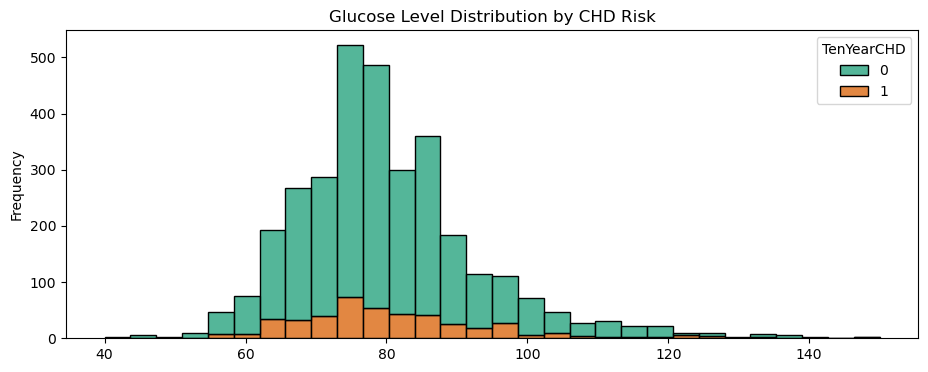

In [21]:
plot_histogram(
    df=df_train_copy,
    column='glucose', 
    bins=30,
    title='Glucose Level Distribution by CHD Risk',
    hue='TenYearCHD',
    legend=True
)

The distribution shows that most individuals, regardless of CHD risk, have glucose levels clustered around the normal range (70-100). However, there is a slight increase in CHD risk among those with higher glucose levels, suggesting that elevated glucose may be associated with an increased risk of CHD. Despite this, there is significant overlap between the groups, indicating that glucose level alone is not a definitive predictor of CHD risk.

#### All features' correlation summary

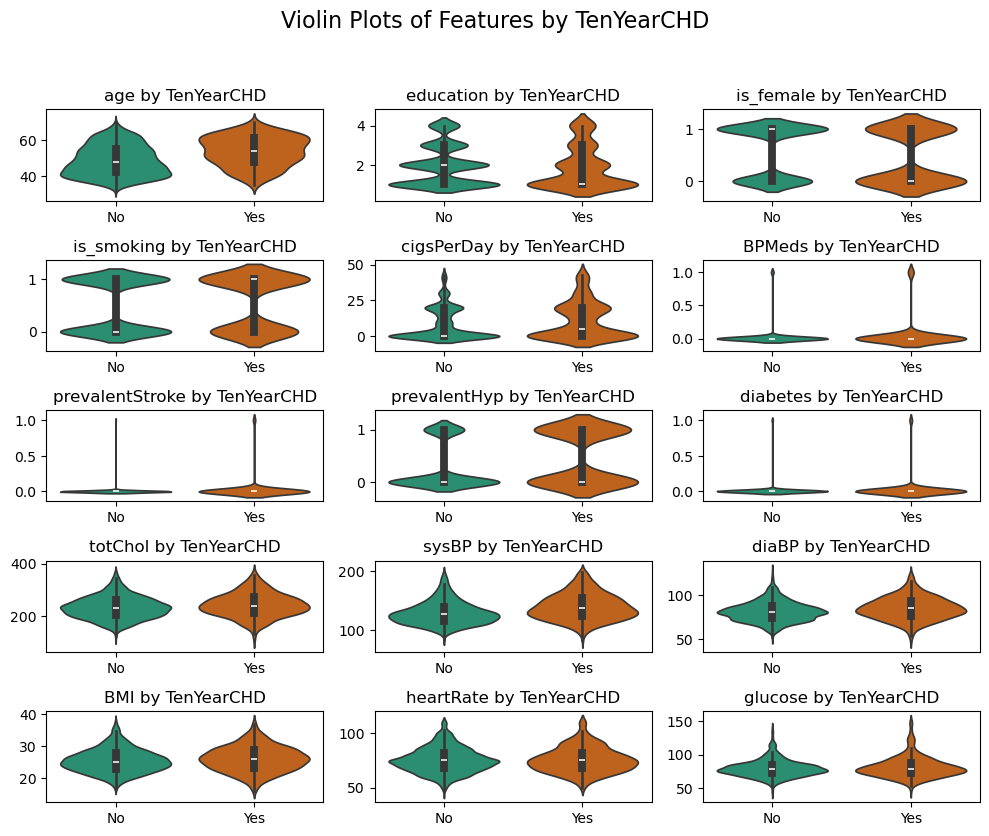

In [22]:
features = [col for col in df_train_copy.columns if col != 'TenYearCHD']

num_features = len(features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 1.75*num_rows))
fig.suptitle('Violin Plots of Features by TenYearCHD', fontsize=16)

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.violinplot(x='TenYearCHD', y=feature, data=df_train_copy, palette='Dark2', 
                   ax=axes[i], hue='TenYearCHD', legend=False)
    axes[i].set_title(f'{feature} by TenYearCHD')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['No', 'Yes'])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

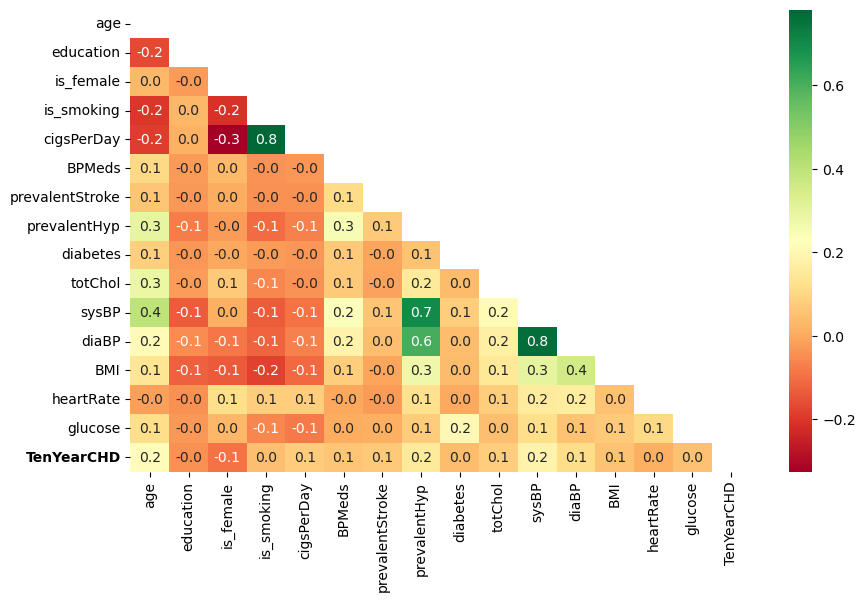

In [23]:
corr = df_train_copy.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 6))

sns.heatmap(corr, mask=mask, annot=True, cmap='RdYlGn', fmt='.1f')

x_labels = plt.gca().get_xticklabels()
y_labels = plt.gca().get_yticklabels()

for label in y_labels:
    if label.get_text() == 'TenYearCHD':
        label.set_fontweight('bold')

plt.show()

Overall, two pairs of features (is_smoking/cigsPerDay and sysBP/diaBP) show a strong correlation which suggests multicollinearity. So, it would be better to remove one of the correlated attributes from the model.

## Logistic Regression

#### model v.1

In this first version, we use a straightforward logistic regression model with all available features and no adjustments to account for class imbalance or threshold tuning. This serves as a baseline to compare against later versions with more refined settings.

In [24]:
columns_to_scale = ['totChol', 'sysBP', 'BMI', 'heartRate', 'glucose']

scaler = StandardScaler()

df_train_copy[columns_to_scale] = scaler.fit_transform(df_train_copy[columns_to_scale])

In [25]:
y = df_train_copy['TenYearCHD']
X = df_train_copy[
    [
        'age', 'education', 'is_female', 'cigsPerDay', 
        'BPMeds', 'prevalentStroke', 'prevalentHyp', 
        'diabetes', 'totChol', 'sysBP', 'BMI',
        'heartRate', 'glucose'
    ]
]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)

(2576, 13)
(645, 13)


In [26]:
y_train.value_counts()

TenYearCHD
0    2215
1     361
Name: count, dtype: int64

In [27]:
y_test.value_counts()

TenYearCHD
0    554
1     91
Name: count, dtype: int64

In [28]:
log_reg_v1 = LogisticRegression(max_iter=5000)

log_reg_v1.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [29]:
X_train_sm = sm.add_constant(X_train)

log_reg_sm = sm.Logit(y_train, X_train_sm).fit(disp=0)

intercept = log_reg_v1.intercept_[0]
coefficients = np.concatenate(([intercept], log_reg_v1.coef_.flatten()))

standard_errors = np.sqrt(np.diag(log_reg_sm.cov_params()))

t_values = coefficients / standard_errors

p_values = [2 * (1 - norm.cdf(np.abs(t_val))) for t_val in t_values]

summary_table = pd.DataFrame({
    'Feature': ['Intercept'] + X_train.columns.tolist(),
    'Coefficient': coefficients,
    'Standard Error': standard_errors,
    't-value': t_values,
    'p-value': p_values
})

print(summary_table)

            Feature  Coefficient  Standard Error  t-value  p-value
0         Intercept        -5.62            0.48   -11.67     0.00
1               age         0.07            0.01     8.76     0.00
2         education        -0.01            0.06    -0.18     0.86
3         is_female        -0.41            0.13    -3.04     0.00
4        cigsPerDay         0.03            0.01     5.51     0.00
5            BPMeds        -0.04            0.31    -0.13     0.90
6   prevalentStroke         0.97            0.56     1.71     0.09
7      prevalentHyp         0.06            0.17     0.32     0.75
8          diabetes         0.16            0.48     0.33     0.74
9           totChol         0.13            0.06     2.08     0.04
10            sysBP         0.28            0.08     3.43     0.00
11              BMI        -0.03            0.06    -0.42     0.68
12        heartRate        -0.01            0.06    -0.22     0.83
13          glucose         0.06            0.06     0.97     

The coefficients represent the log-odds of the target variable (CHD risk) given a one-unit change in the predictor variable, while holding all other variables constant. 

**Key Insights**
- Significant Predictors: age, sex (is_female), cigarettes per day (cigsPerDay), cholesterol level (totChol), and systolic blood pressure (sysBP) appear to be significant predictors of CHD risk based on their p-values.
- Non-significant Predictors: features like education, blood pressure medication (BPMeds), prevalent stroke (prevalentStroke), prevalent hypertension (prevalentHyp), diabetes, BMI, heartRate, glucose levels.

Direction of Influence:
- Positive coefficients (age, cigarettes per day, cholesterol level, systolic blood pressure) suggest these factors are associated with a higher risk of CHD.
- Negative coefficients (being female) suggest a lower risk of CHD.

In [30]:
y_pred_v1 = log_reg_v1.predict(X_test)

cm_v1 = confusion_matrix(y_test, y_pred_v1)

cm_df_v1 = pd.DataFrame(cm_v1, index=['Actual No', 'Actual Yes'], columns=['Predicted No', 'Predicted Yes'])

print("Confusion Matrix\n")
print(cm_df_v1)

Confusion Matrix

            Predicted No  Predicted Yes
Actual No            551              3
Actual Yes            88              3


In [31]:
print("Classification Report\n\n", classification_report(y_test, y_pred_v1))

Classification Report

               precision    recall  f1-score   support

           0       0.86      0.99      0.92       554
           1       0.50      0.03      0.06        91

    accuracy                           0.86       645
   macro avg       0.68      0.51      0.49       645
weighted avg       0.81      0.86      0.80       645



In the first version of the model, while overall accuracy is high at 86%, the recall for the positive class (CHD risk) is notably poor at only 3%. Since the primary goal of this model is to identify patients at risk of CHD, recall is crucial. The low recall indicates that the model is failing to correctly identify a significant number of actual positive cases, highlighting a need for further model adjustments to improve sensitivity to CHD risk.

#### model v.2 (balanced)

In this version, we apply class_weight='balanced' to the logistic regression model to address the class imbalance in the dataset. This adjustment aims to improve the model's ability to correctly identify CHD risk by giving more importance to the minority class, potentially enhancing recall for positive cases.

In [32]:
log_reg_v2 = LogisticRegression(class_weight='balanced', max_iter=5000)

log_reg_v2.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=5000)

In [33]:
y_pred_v2 = log_reg_v2.predict(X_test)

cm_v2 = confusion_matrix(y_test, y_pred_v2)

cm_df_v2 = pd.DataFrame(cm_v2, index=['Actual No', 'Actual Yes'], columns=['Predicted No', 'Predicted Yes'])

print("Confusion Matrix\n")
print(cm_df_v2)

Confusion Matrix

            Predicted No  Predicted Yes
Actual No            354            200
Actual Yes            35             56


In [34]:
print("Classification Report\n\n", classification_report(y_test, y_pred_v2))

Classification Report

               precision    recall  f1-score   support

           0       0.91      0.64      0.75       554
           1       0.22      0.62      0.32        91

    accuracy                           0.64       645
   macro avg       0.56      0.63      0.54       645
weighted avg       0.81      0.64      0.69       645



In [35]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(log_reg_v2, X_train, y_train, cv=cv, scoring='recall') 

print(f"Cross-Validation Recall Scores: {[f'{score:.2f}' for score in scores]}")
print(f"Mean Recall: {scores.mean():.2f}")

Cross-Validation Recall Scores: ['0.67', '0.61', '0.72', '0.71', '0.64']
Mean Recall: 0.67


This second version demonstrates a significant improvement in recall for the positive class (CHD risk) compared to the first version. However, there is still some room for further improvement in recall, even if it might come at the cost of other metrics. In the next version, we will explore adjusting the decision threshold to see if we can achieve better recall.

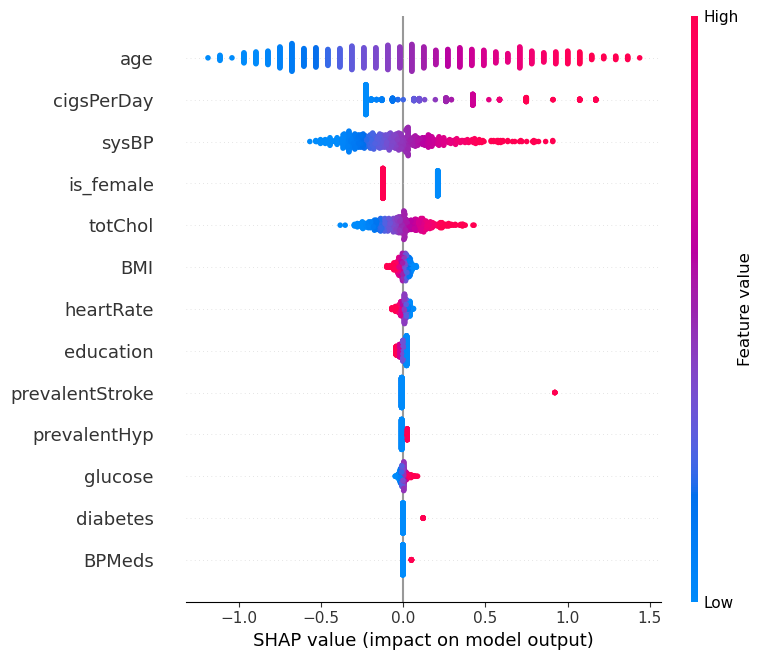

In [36]:
explainer = shap.Explainer(log_reg_v2, X_train)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

#### model v.3 (custom threshold)

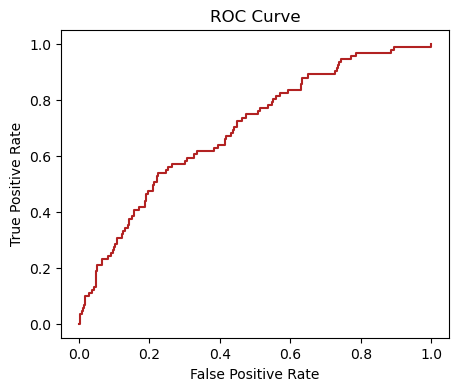

In [37]:
y_pred_proba = log_reg_v2.predict_proba(X_test)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label='ROC Curve', color='firebrick')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

This ROC curve for the second version of the model illustrates the trade-off between the true positive rate (recall) and the false positive rate at various threshold levels. 

In [38]:
y_pred_v3 = (y_pred_proba >= 0.4).astype(int)

cm_v3 = confusion_matrix(y_test, y_pred_v3)

cm_df_v3 = pd.DataFrame(cm_v3, index=['Actual No', 'Actual Yes'], columns=['Predicted No', 'Predicted Yes'])

print("Confusion Matrix\n")
print(cm_df_v3)

Confusion Matrix

            Predicted No  Predicted Yes
Actual No            264            290
Actual Yes            21             70


In [39]:
print("Classification Report\n\n", classification_report(y_test, y_pred_v3))

Classification Report

               precision    recall  f1-score   support

           0       0.93      0.48      0.63       554
           1       0.19      0.77      0.31        91

    accuracy                           0.52       645
   macro avg       0.56      0.62      0.47       645
weighted avg       0.82      0.52      0.58       645



In the third version, the recall for the positive class (CHD risk) has improved to 77%, further enhancing the model's ability to identify patients at risk. However, this comes at the cost of a higher number of false positives, as indicated by a decrease in overall accuracy to 52%.

Choosing between version 2 and version 3 depends on the user's objective. If the goal is to identify as many at-risk patients as possible, regardless of the increased number of false positives and the associated costs of additional testing, then version 3 is preferable. Conversely, if a more conservative approach is needed, with fewer false positives, version 2 would be the recommended choice.

## TL;DR

This project focused on predicting the 10-year CHD (Coronary Heart Disease) risk using logistic regression, involving several steps from data cleaning to model evaluation.

1. Data Cleaning: Approximately 15% of the dataset had missing values. These missing values were filled using mean, median, and mode imputation methods to ensure completeness and maintain data integrity.

2. Exploratory Data Analysis (EDA): We explored all 15 features (variables) in the dataset to understand their distributions and potential impact on the target variable (ten year CHD risk). The analysis revealed that while each feature had some effect on CHD risk, no single feature stood out as the most significant predictor, with correlation values ranging between -0.1 and 0.2. Additionally, some of the features had multicollinearity issues (e.g., systolic and diastolic blood pressure, smoking status and cigarettes per day) and were removed from the analysis.

3. Logistic Regression Modeling: Three versions of a logistic regression model were developed:

    - Version 1: A baseline model with all features included and no adjustments.
        - Metrics: Accuracy: 86%, Recall for CHD risk: 3%, Precision: 50%.
        - Observation: High accuracy but very low recall for the positive class, indicating that the model fails to identify most at-risk patients.
    - Version 2: An improved model using class_weight='balanced' to address class imbalance.
        - Metrics: Accuracy: 64%, Recall for CHD risk: 62%, Precision: 22%.
        - Observation: Significant improvement in recall compared to the first version, indicating better identification of at-risk patients, though some precision is sacrificed.
    - Version 3: A further refined model with an adjusted decision threshold (0.4) to maximize recall while controlling false positives.
        - Metrics: Accuracy: 52%, Recall for CHD risk: 77%, Precision: 19%.
        - Observation: The recall is further improved, capturing more true positive cases, but at the cost of a higher false positive rate and lower overall accuracy. 

The models showed progressive improvements in recall, though the third version demonstrated that choosing the optimal model depends on the user's objectives — whether to prioritize capturing as many at-risk patients as possible or to minimize the number of false positives.

4. Conclusion: While logistic regression provided a useful starting point, it may not be the ideal model type for this problem due to its limitations in handling complex relationships. Additionally, the relatively small dataset (around 3,000 entries) limits the model's learning capacity. Considering the significant impact of CHD, which affects millions of people and contributes to numerous deaths annually, exploring more sophisticated modeling techniques and obtaining a larger dataset could potentially yield better predictive performance.